# Processamento de Imagens - Trabalho 1

<font size=3>Aluno: Gabriel dos Santos Vieira  -  DRE: 114029198</font>

## Métodos utilizados 

<font size=3> A transformação escolhida para realizar o trabalho foi a transformação conhecida como "Twirl", ela é uma transformação que foi vista em aula que consiste em "torcer" a imagem a partir de um ponto pré fixado. Para realizar a interpolação da imagem para obtermos a imagem final da imagem modificada anteriormente foi utilizada a interpolação bilinear pela sua praticidade e efetividade.  </font>

<font size=3> Para os filtros de detecção de contorno foram escolhidos o filtro de Sobel e o filtro de Prewitt, ambos vistos em sala de aula. A seguir ao longo do código irei explicar com detalhes as funções implementadas e ao final teremos os resultados do trabalho.  </font>

In [1]:
# importing libs 
import argparse
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import time


<font size=3> A seguir temos a função que implementa a interpolação bilinear, no começo verificamos o tamanho da imagem que faremos a interpolação. Feito isso agora podemos lidar com as bordas da imagem, pois caso algum pixel contínuo da transformação seja maior que os limites da imagem, mesmo que utilizemos o valor inteiro mais próximo utilizando o método __floor()__ , pode ser que esse pixel contínuo esteja em um lugar muito fora da imagem original, sendo assim precisamos tratar esses casos também. O que foi feito é, caso o pixel esteja fora no eixo de y, ele vai procurar os vizinhos mais próximos no eixo x e ao contrário da mesma forma se estiver fora do eixo de x, ele vai procurar os vizinhos mais próximos do eixo de y. Caso o pixel esteja fora dos limites de x e de y o valor da cor é estipulada a 0 (Eu também fiz como a cor sendo o valor do pixel do limite de x e de y antes, porém não vi diferença ao utilizar a interpolação entre as duas formas). Após tratar esses casos a interpolação ocorre normalmente com sua fórmula original.  </font>

In [2]:
# bilinear interpolation
def bilinear_interpolation(x,y,image):
    try:
        h,w,_ = image.shape
    except:
        h,w = image.shape

    u0 = int(math.floor(x))
    v0 = int(math.floor(y))
    dx = x-u0
    dy = y-v0

    # dealing with the borders of the image
    if u0 >= h-1:
        u0= h-1
        if v0>=w-1:
            v0 = w-1
            color = 0
            #color = image[u0,v0]
            return color

        color = (1-dy)*image[u0,v0] + dy*image[u0,v0+1]
        return color

    if v0 >=w-1:
        v0= w-1
        if u0>=h-1:
            u0=h-1
            color = 0
            #color = image[u0,v0]
            return color

        color = (1-dx)*image[u0,v0] + dx*image[u0+1,v0]
        return color

    
    # Bilinear formula for estimating the color
    color = ( (1-dx) * (1-dy) * image[u0,v0] + (dx)*(1-dy) * image[u0+1,v0] +
    (1-dx)*(dy) * image[u0,v0+1] + (dx)*(dy) * image[u0+1,v0+1] )

    return color

<font size=3> Aqui abaixo temos a transformação não-linear chamada de "Twirl", nela escolhemos os parâmetros do y e x centrais como sendo a metade do tamanho da imagem em seus respectivos eixos. O raio máximo é estipulado como 40% do maior valor dentre os tamanhos da imagem e o ângulo estipulado é 2. A maior dificuldade da criação deste método foi conseguir entender a utilização da matriz inversa para a realização da transformação e a necessidade da interpolação, mas esse obstáculo foi ultrapassado e o exercício foi feito :) . Foi testado também a interpolação do Nearest Neighbor, porém ela trazia um resultado ruim e não foi utilizada até o final em nenhum resultado.
 </font>

In [3]:
# Twirl transformation

def twirl(image):
    x,y,_ = image.shape

    transformed_image = np.copy(image)
    
    # Setting parameters Xc and Yc as half of the size of each one, the radius to 40% of the major size
    # and the angle to 2.
    y_center = y/2
    x_center = x/2
    r_max = int(0.4*max(x,y))
    angle_function = 2

    for i in range(x):

        dx = float(i) - x_center
        dx_2 = dx**2

        for j in range(y):

            dy = float(j) - y_center
            dy_2 = dy**2
            r = np.sqrt((dx_2) + (dy_2))
            angle_pixels = np.arctan2(dy,dx)

            betha = angle_pixels + angle_function*((r_max - r)/r_max)

            if r <= r_max:

                new_x = x_center+r*np.cos(betha)
                new_y = y_center+r*np.sin(betha)
                aux = bilinear_interpolation(new_x,new_y,image)
                # Nearest Neighbor
                # aux = image[math.floor(new_x),math.floor(new_y)]
            else:
                aux = image[i,j]

            transformed_image[i,j] = aux

#     cv2.imwrite('twirl_result.png',transformed_image)
    ax1 = plt.subplot(111)
    im1 = ax1.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    plt.show()

<font size=3> Para os filtros de detecção de contorno temos primeiro o prewitt, como ele foi visto em sala não entraremos em detalhes sobre as funções dele. Dos detalhes que adicionei ao prewitt, estamos trabalhando com a imagem em tons de cinza para facilitar os cálculos da imagem, além disso como o opencv cria matrizes de tipo 'uint8' quando carrega a imagem, fica difícil fazer transformações na própria imagem (ou cópias dela) que deixem ela com valores em float ou maiores que 255, para isso criamos uma nova matriz com as mesmas dimensões da imagem porém com tipo float para lidar com nossas contas em cima dela. Ao final da convolução da imagem teremos essa nova matriz com seus valores e não teremos garantia do range de valores que ela cobre, por isso então teremos que trazer de volta o range da imagem para entre 0 e 255 (o método clip do numpy nos ajuda com essa tarefa) e após isso poderemos transformar de volta a imagem para 'uint8' e assim a imagem voltará a ter valores inteiros e poderá ser exibida sem problemas. Após isso tudo, também foram usadas três formas de avaliação do método no decorrer da implementação, primeiro foi utilizada uma normalização na imagem, depois foi utilizada a imagem sem normalização e sem nenhuma interferência no método como um todo e por último foi utilizada uma taxa de threshold onde todos os valores menores que o threshold eram modificados para 0 e os valores acima do threshold não eram modificados. </font>

In [4]:
# Prewitt operator for edge detection 
def prewitt(image):

    x,y,_ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    transformed_image = np.zeros((x,y),dtype=float)

    for i in range(1,x-1):
        for j in range(1,y-1):

            gx = 0
            gy = 0

            gx += image[i-1,j-1] + image[i-1,j] + image[i-1,j+1]
            gx -= image[i+1,j-1] + image[i+1,j] + image[i+1,j+1]

            gy += image[i-1,j-1] + image[i,j-1] + image[i+1,j-1]
            gy -= image[i-1,j+1] + image[i,j+1] + image[i+1,j+1]

            gradient_length = np.hypot(gx,gy)

            transformed_image[i,j] = gradient_length


#     transformed_image *= 255 / (np.max(transformed_image))

    np.clip(transformed_image,0,255,out=transformed_image)
    transformed_image = np.uint8(transformed_image)

    threshold = 20 
    threshold_matrix = transformed_image>=threshold
    transformed_image *= threshold_matrix
#     cv2.imwrite('prewitt_result.png',transformed_image)
    ax1 = plt.subplot(111)
    im1 = ax1.imshow(transformed_image,cmap='gray')
    plt.show()

<font size=3> E por último temos o filtro de detecção de contorno de Sobel, este também foi um filtro visto em sala de aula e por isso não entrarei em muitos detalhes de como ele funciona. Os mesmos problemas e mesmas ideias realizadas no filtro de Prewitt foram feitos aqui, assim como a avaliação e a ordem de avaliação das imagens (Esta ordem de avaliação das imagens também retrata a ordem que foram salvas as imagens nas suas respectivas pastas) </font>

In [5]:
# Sobel operator for edge detection 
def sobel(image):

    x,y,_ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    transformed_image = np.zeros((x,y),dtype=float)

    for i in range(1,x-1):
        for j in range(1,y-1):

            gx = 0
            gy = 0

            gx += image[i-1,j-1] + 2*image[i-1,j] + image[i-1,j+1]
            gx -= image[i+1,j-1] + 2*image[i+1,j] + image[i+1,j+1]

            gy += image[i-1,j-1] + 2*image[i,j-1] + image[i+1,j-1]
            gy -= image[i-1,j+1] + 2*image[i,j+1] + image[i+1,j+1]

            gradient_length = np.hypot(gx,gy)

            transformed_image[i,j] = gradient_length

#     transformed_image *= 255 / (np.max(transformed_image))

    np.clip(transformed_image,0,255,out=transformed_image)
    transformed_image = np.uint8(transformed_image)

    threshold = 20 
    threshold_matrix = transformed_image>=threshold
    transformed_image *= threshold_matrix
#     cv2.imwrite('sobel_result.png',transformed_image)
    ax1 = plt.subplot(111)
    im1 = ax1.imshow(transformed_image,cmap='gray')
    plt.show()

<font size=3> Para executar o programa é só rodar todas as células criadas anteriormente e rodar a próxima célula para chamar as funções. Coloque um endereço de imagem e tire dos comentários um método para ser executado. </font>

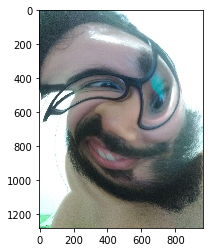

In [6]:
# to run the program put a valid path to the image and choose one or more functions
path_image = './originais/face.jpg'

image = cv2.imread(path_image)

twirl(image)

#sobel(image)

#prewitt(image)

## <font size=8> Resultados </font>

<font size=3> Nos resultados aqui no notebook, indicaremos apenas as melhores versões das imagens para não deixar o notebook gigantesco. Caso queira ver o resultado com outras variações as imagens estarão na pasta com o nome respectivo do método </font>

### <font size=6.5> Twirl </font>

<img src="twirl/twirl_result_face.png" alt="Drawing" style="width: 500px;"/>

<img src="twirl/twirl_result_flower.png" alt="Drawing" style="width: 500px;"/>

<img src="twirl/twirl_result_vitral.png" alt="Drawing" style="width: 500px;"/>

<img src="twirl/twirl_result_tico.png" alt="Drawing" style="width: 500px;"/>

<img src="twirl/twirl_result_gear.png" alt="Drawing" style="width: 500px;"/>

### <font size=6.5> Prewitt </font>

<img src="prewitt/prewitt_result_face3.png" alt="Drawing" style="width: 500px;"/>

<img src="prewitt/prewitt_result_flower3.png" alt="Drawing" style="width: 500px;"/>

<img src="prewitt/prewitt_result_vitral3.png" alt="Drawing" style="width: 500px;"/>

<img src="prewitt/prewitt_result_tico3.png" alt="Drawing" style="width: 500px;"/>

<img src="prewitt/prewitt_result_gear3.png" alt="Drawing" style="width: 500px;"/>

### <font size=6.5>  Sobel </font>

<img src="sobel/sobel_result_face3.png" alt="Drawing" style="width: 500px;"/>

<img src="sobel/sobel_result_flower3.png" alt="Drawing" style="width: 500px;"/>

<img src="sobel/sobel_result_vitral3.png" alt="Drawing" style="width: 700px;"/>

<img src="sobel/sobel_result_tico3.png" alt="Drawing" style="width: 500px;"/>

<img src="sobel/sobel_result_gear3.png" alt="Drawing" style="width: 500px;"/>